<a href="https://colab.research.google.com/github/hyuntaedo/Deep_learning/blob/main/Parking_data_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 데이터 패키지 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn import metrics

import tensorflow as tf
import datetime

from numpy import absolute

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV



In [2]:
train = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/Data_Folder/parking_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/Data_Folder/parking_data/test.csv')
age_gender = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/Data_Folder/parking_data/age_gender_info.csv')
submission = pd.read_csv('/content/drive/MyDrive/Data_Folder/data/Data_Folder/parking_data/age_gender_info.csv')

## 2. EDA

### 2-1 데이터 전처리변환

In [3]:
print('TrainShape : {}'.format(train.shape))
print("TestSahpe : {}".format(test.shape))
print("ageShape : {}".format(age_gender.shape))

TrainShape : (2952, 15)
TestSahpe : (1022, 14)
ageShape : (16, 23)


In [4]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')

In [5]:
test.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수'],
      dtype='object')

In [6]:
age_gender.columns

Index(['지역', '10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)', '20대(여자)',
       '20대(남자)', '30대(여자)', '30대(남자)', '40대(여자)', '40대(남자)', '50대(여자)',
       '50대(남자)', '60대(여자)', '60대(남자)', '70대(여자)', '70대(남자)', '80대(여자)',
       '80대(남자)', '90대(여자)', '90대(남자)', '100대(여자)', '100대(남자)'],
      dtype='object')

In [7]:
age_gender['지역']

0        경상북도
1        경상남도
2       대전광역시
3         경기도
4        전라북도
5         강원도
6       광주광역시
7        충청남도
8       부산광역시
9     제주특별자치도
10      울산광역시
11       충청북도
12       전라남도
13      대구광역시
14      서울특별시
15    세종특별자치시
Name: 지역, dtype: object

In [8]:
Korean_English = {
    '경상북도':'GyoungBook',
    '경상남도':'GyoungNam',
    '대전광역시':'Daegeon',
    '경기도':'Gyeonggi',
    '전라북도':'GeonBook',
    '강원도':'Gangwon',
    '광주광역시':'Gwangzoo',
    '충청남도':'ChoongNam',
    '부산광역시':'Busan',
    '제주특별자치도':'Jeju',
    '울산광역시':'Ulsan',
    '충청북도':'CoongBook',
    '전라남도':'GeonNam',
    '대구광역시':'Daegu',
    '서울특별시':'Seoul',
    '세종특별자치시':'Sejong',
}

In [9]:
train['지역'] = train['지역'].map(Korean_English)
test['지역'] = test['지역'].map(Korean_English)
age_gender['지역'] = age_gender['지역'].map(Korean_English)

In [10]:
train = train.rename(columns={
    '단지코드':'complex_code', 
    '총세대수':'total_number_household', 
    '임대건물구분':'rental_bulding_classification', 
    '지역':'area', 
    '공급유형':'supply_type', 
    '전용면적':'exclusive_area', 
    '전용면적별세대수':'number_of_household_by_area', 
    '공가수':'public_price',
    '자격유형':'qualification_type', 
    '임대보증금':'rental_deposit', 
    '임대료':'rent', 
    '도보 10분거리 내 지하철역 수(환승노선 수 반영)':'subway',
    '도보 10분거리 내 버스정류장 수':'bus', 
    '단지내주차면수':'parking_area', 
    '등록차량수':'registried_vehicle',
})

In [11]:
test = test.rename(columns={
    '단지코드':'complex_code', 
    '총세대수':'total_number_household', 
    '임대건물구분':'rental_bulding_classification', 
    '지역':'area', 
    '공급유형':'supply_type', 
    '전용면적':'exclusive_area', 
    '전용면적별세대수':'number_of_household_by_area', 
    '공가수':'public_price',
    '자격유형':'qualification_type', 
    '임대보증금':'rental_deposit', 
    '임대료':'rent', 
    '도보 10분거리 내 지하철역 수(환승노선 수 반영)':'subway',
    '도보 10분거리 내 버스정류장 수':'bus', 
    '단지내주차면수':'parking_area', 
})

In [12]:
age_gender = age_gender.rename(columns={
    '지역':'area', 
    '10대미만(여자)':'under_10_female', 
    '10대미만(남자)':'under_10_male', 
    '10대(여자)':'10_female', 
    '10대(남자)':'10_male', 
    '20대(여자)':'20_female',
    '20대(남자)':'20_male', 
    '30대(여자)':'30_female', 
    '30대(남자)':'30_male', 
    '40대(여자)':'40_female', 
    '40대(남자)':'40_male', 
    '50대(여자)':'50_female',
    '50대(남자)':'50_male', 
    '60대(여자)':'60_female', 
    '60대(남자)':'60_male', 
    '70대(여자)':'70_female', 
    '70대(남자)':'70_male', 
    '80대(여자)':'80_female',
    '80대(남자)':'80_male', 
    '90대(여자)':'90_female', 
    '90대(남자)':'90_male', 
    '100대(여자)':'100_female', 
    '100대(남자)':'100_male'
})

In [13]:
age_gender

,area,under_10_female,under_10_male,10_female,10_male,20_female,20_male,30_female,30_male,40_female,40_male,50_female,50_male,60_female,60_male,70_female,70_male,80_female,80_male,90_female,90_male,100_female,100_male
0,GyoungBook,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,GyoungNam,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,Daegeon,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,Gyeonggi,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,GeonBook,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
5,Gangwon,0.028888,0.030682,0.051287,0.052712,0.060374,0.063157,0.059821,0.054321,0.076201,0.068002,0.087266,0.072177,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
6,Gwangzoo,0.031994,0.034566,0.049851,0.050254,0.065084,0.066875,0.066888,0.064416,0.080028,0.079183,0.079902,0.067443,0.075930,0.059586,0.048552,0.031754,0.029749,0.010341,0.006343,0.000895,0.000353,0.000013
7,ChoongNam,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,0.073418,0.079299,0.069167,0.070278,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123
8,Busan,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,0.060769,0.082899,0.068855,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028
9,Jeju,0.034690,0.036695,0.060094,0.063080,0.069135,0.069667,0.050808,0.048026,0.080548,0.072530,0.088403,0.068930,0.074248,0.055717,0.047944,0.033054,0.026836,0.011332,0.006832,0.000982,0.000368,0.000082


In [14]:
test

,complex_code,total_number_household,rental_bulding_classification,area,supply_type,exclusive_area,number_of_household_by_area,public_price,qualification_type,rental_deposit,rent,subway,bus,parking_area
0,C1072,754,아파트,Gyeonggi,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,Gyeonggi,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,Gyeonggi,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,Gyeonggi,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,Gyeonggi,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,C1267,675,아파트,GyoungNam,행복주택,36.77,126,38.0,L,-,-,0.0,1.0,467.0
1018,C2189,382,아파트,GeonBook,국민임대,29.19,96,45.0,H,6872000,106400,0.0,2.0,300.0
1019,C2189,382,아파트,GeonBook,국민임대,29.19,20,45.0,H,6872000,106400,0.0,2.0,300.0
1020,C2189,382,아파트,GeonBook,국민임대,39.45,202,45.0,H,13410000,144600,0.0,2.0,300.0


In [15]:
train

,complex_code,total_number_household,rental_bulding_classification,area,supply_type,exclusive_area,number_of_household_by_area,public_price,qualification_type,rental_deposit,rent,subway,bus,parking_area,registried_vehicle
0,C2483,900,아파트,GyoungBook,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,GyoungBook,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,GyoungBook,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,GyoungBook,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,GyoungBook,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,Gangwon,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,Gangwon,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,Gangwon,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,Gangwon,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0


In [16]:
test.isna().sum()

complex_code                       0
total_number_household             0
rental_bulding_classification      0
area                               0
supply_type                        0
exclusive_area                     0
number_of_household_by_area        0
public_price                       0
qualification_type                 2
rental_deposit                   180
rent                             180
subway                            42
bus                                0
parking_area                       0
dtype: int64

In [17]:
train.isna().sum()

complex_code                       0
total_number_household             0
rental_bulding_classification      0
area                               0
supply_type                        0
exclusive_area                     0
number_of_household_by_area        0
public_price                       0
qualification_type                 0
rental_deposit                   569
rent                             569
subway                           211
bus                                4
parking_area                       0
registried_vehicle                 0
dtype: int64

In [18]:
data_frame = train.append(test)

In [19]:
data_frame

,complex_code,total_number_household,rental_bulding_classification,area,supply_type,exclusive_area,number_of_household_by_area,public_price,qualification_type,rental_deposit,rent,subway,bus,parking_area,registried_vehicle
0,C2483,900,아파트,GyoungBook,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,GyoungBook,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,GyoungBook,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,GyoungBook,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,GyoungBook,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,C1267,675,아파트,GyoungNam,행복주택,36.77,126,38.0,L,-,-,0.0,1.0,467.0,NaN
1018,C2189,382,아파트,GeonBook,국민임대,29.19,96,45.0,H,6872000,106400,0.0,2.0,300.0,NaN
1019,C2189,382,아파트,GeonBook,국민임대,29.19,20,45.0,H,6872000,106400,0.0,2.0,300.0,NaN
1020,C2189,382,아파트,GeonBook,국민임대,39.45,202,45.0,H,13410000,144600,0.0,2.0,300.0,NaN


#### Delete of BadString

In [20]:
data_frame = data_frame.replace('-',np.nan)

#### Change Numeric

In [21]:
data_frame[['rent','rental_deposit']] == data_frame[['rent','rental_deposit']].apply(pd.to_numeric)

,rent,rental_deposit
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
1017,False,False
1018,False,False
1019,False,False
1020,False,False


In [22]:
df_shops = data_frame[data_frame['rental_bulding_classification'] == '상가']
df_apt = data_frame[data_frame['rental_bulding_classification'] == '아파트']

### Missing Value

In [23]:
print("상가 임대료 missing value count: {}".format(df_shops.rent.isna().sum()), "out of {}".format(df_shops.shape[0]))
print("상가 임대보증금 missing value count:{}".format(df_shops.rental_deposit.isna().sum()) , "out of {}".format(df_shops.shape[0]))

print("아파트 임대료 missing value count: {}".format(df_apt.rent.isna().sum()),  "out of {}".format(df_apt.shape[0]))
print("아파트 임대보증금 missing value count:{}".format(df_apt.rental_deposit.isna().sum()), "out of {}".format(df_apt.shape[0]))

상가 임대료 missing value count: 739 out of 739
상가 임대보증금 missing value count:739 out of 739
아파트 임대료 missing value count: 37 out of 3235
아파트 임대보증금 missing value count:28 out of 3235


In [24]:
df_apt.bus.fillna((df_apt.rental_deposit.median()),inplace=True)
df_apt.subway.fillna((df_apt.rental_deposit.median()),inplace=True)
df_apt.rental_deposit.fillna((df_apt.rental_deposit.median()),inplace=True)
df_apt.rent.fillna((df_apt.rent.median()),inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [25]:
df_apt.isna().sum()

complex_code                       0
total_number_household             0
rental_bulding_classification      0
area                               0
supply_type                        0
exclusive_area                     0
number_of_household_by_area        0
public_price                       0
qualification_type                 2
rental_deposit                     0
rent                               0
subway                             0
bus                                0
parking_area                       0
registried_vehicle               845
dtype: int64

In [26]:
df_apt

,complex_code,total_number_household,rental_bulding_classification,area,supply_type,exclusive_area,number_of_household_by_area,public_price,qualification_type,rental_deposit,rent,subway,bus,parking_area,registried_vehicle
0,C2483,900,아파트,GyoungBook,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,GyoungBook,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,GyoungBook,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,GyoungBook,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,GyoungBook,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,C1267,675,아파트,GyoungNam,행복주택,36.77,126,38.0,L,2.1015e+07,159960,0.0,1.0,467.0,NaN
1018,C2189,382,아파트,GeonBook,국민임대,29.19,96,45.0,H,6872000,106400,0.0,2.0,300.0,NaN
1019,C2189,382,아파트,GeonBook,국민임대,29.19,20,45.0,H,6872000,106400,0.0,2.0,300.0,NaN
1020,C2189,382,아파트,GeonBook,국민임대,39.45,202,45.0,H,13410000,144600,0.0,2.0,300.0,NaN


In [27]:
df_shops

,complex_code,total_number_household,rental_bulding_classification,area,supply_type,exclusive_area,number_of_household_by_area,public_price,qualification_type,rental_deposit,rent,subway,bus,parking_area,registried_vehicle
88,C1925,601,상가,Gangwon,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
89,C1925,601,상가,Gangwon,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
90,C1925,601,상가,Gangwon,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
91,C1925,601,상가,Gangwon,임대상가,72.16,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
101,C1874,619,상가,ChoongNam,임대상가,12.62,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,C1729,627,상가,Gangwon,임대상가,32.46,1,0.0,D,NaN,NaN,0.0,5.0,131.0,NaN
329,C1729,627,상가,Gangwon,임대상가,34.86,1,0.0,D,NaN,NaN,0.0,5.0,131.0,NaN
330,C1729,627,상가,Gangwon,임대상가,35.76,1,0.0,D,NaN,NaN,0.0,5.0,131.0,NaN
331,C1729,627,상가,Gangwon,임대상가,50.08,1,0.0,D,NaN,NaN,0.0,5.0,131.0,NaN


### Response Transformation

0.265755578370876


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


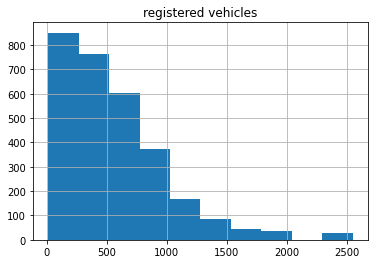

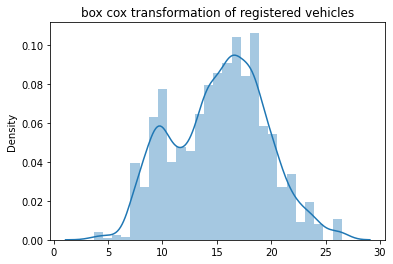

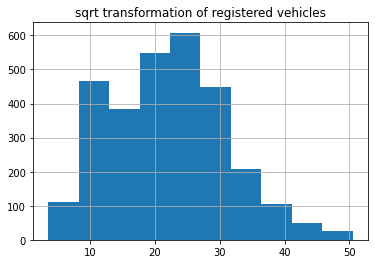

In [28]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

plt.figure()
plt.title('registered vehicles')
train['registried_vehicle'].hist()

y,train_fitted_lambda= boxcox(train['registried_vehicle'],lmbda=None)

plt.figure()
plt.title('box cox transformation of registered vehicles')
sns.distplot(y)
print(train_fitted_lambda)

plt.figure()
plt.title('sqrt transformation of registered vehicles')
np.sqrt(train['registried_vehicle']).hist()

### Correlation

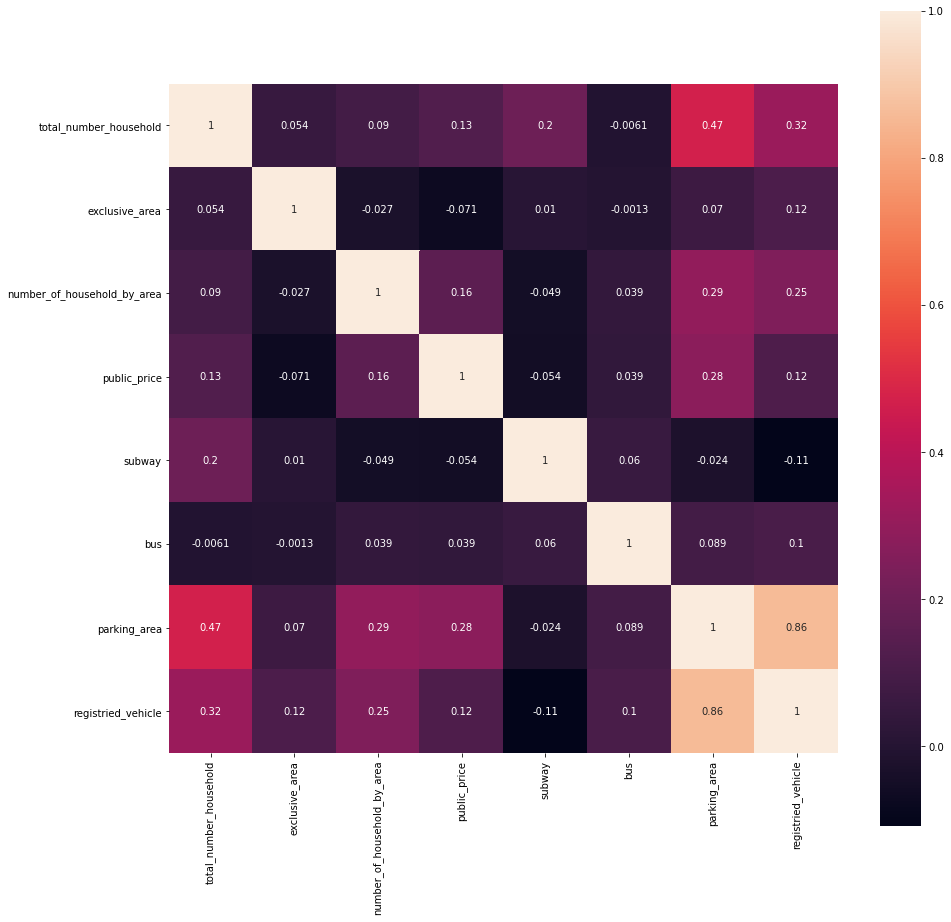

In [29]:
corrmat = data_frame.corr()
plt.subplots(figsize=[15,15])
sns.heatmap(corrmat,square=True,annot=True)

c = corrmat.abs()
s = c.unstack()
so = s.sort_values(ascending=True).drop_duplicates()

## Total EDA

In [30]:
remove_list=['complex_code','registried_vehicle']


numeric_features=data_frame.select_dtypes(include=[np.number] ).columns.tolist()
numeric_features=list(set(numeric_features) - set(remove_list))

cat_features=data_frame.select_dtypes(exclude=np.number).columns.tolist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4828b81090>,
      dtype=object)

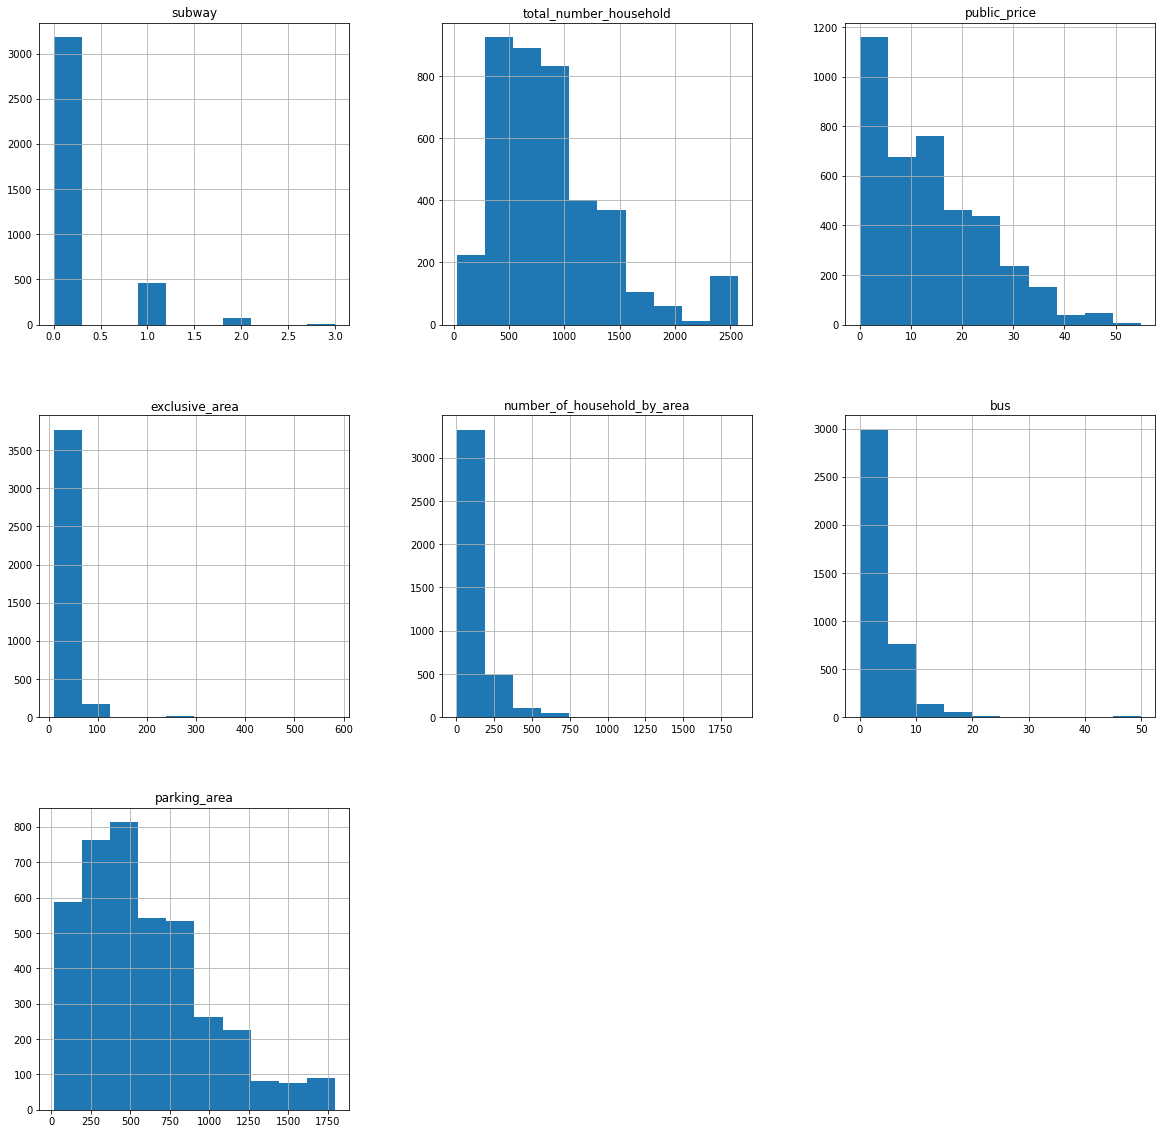

In [31]:
data_frame[numeric_features].hist( figsize=(20,20))

In [32]:
for col in cat_features: 
    try:      
        print("---- %s ---" % col)
        print(data_frame[col].value_counts(dropna=False))
    except ValueError:
        print('This column can not be represented. Check datatype')

---- complex_code ---
C1439    48
C2132    47
C2676    46
C1859    40
C1790    33
         ..
C2216     2
C2188     1
C2437     1
C2340     1
C2520     1
Name: complex_code, Length: 573, dtype: int64
---- rental_bulding_classification ---
아파트    3235
상가      739
Name: rental_bulding_classification, dtype: int64
---- area ---
Gyeonggi      880
GyoungNam     454
Busan         416
Daegeon       322
Gangwon       293
CoongBook     214
ChoongNam     199
GeonNam       188
Gwangzoo      187
GyoungBook    177
GeonBook      150
Daegu         138
Jeju          117
Ulsan         109
Sejong         66
Seoul          64
Name: area, dtype: int64
---- supply_type ---
국민임대         2380
임대상가          739
행복주택          337
공공임대(10년)     240
영구임대          197
공공임대(50년)      44
공공임대(분납)       18
장기전세            9
공공분양            7
공공임대(5년)        3
Name: supply_type, dtype: int64
---- qualification_type ---
A      2373
D       749
H       247
J       198
C       129
I        56
K        49
E        47
L  

### Age and Gender -> area

In [33]:
age_gender.columns

Index(['area', 'under_10_female', 'under_10_male', '10_female', '10_male',
       '20_female', '20_male', '30_female', '30_male', '40_female', '40_male',
       '50_female', '50_male', '60_female', '60_male', '70_female', '70_male',
       '80_female', '80_male', '90_female', '90_male', '100_female',
       '100_male'],
      dtype='object')

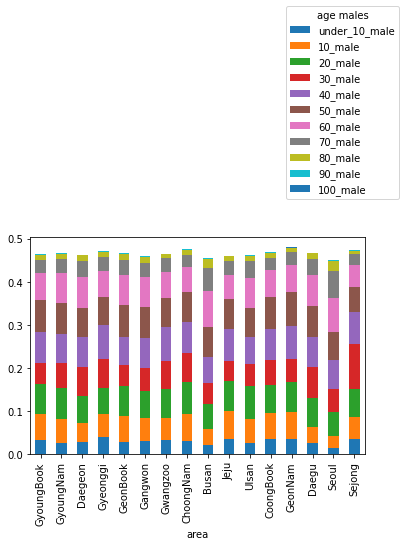

In [34]:
age_gender[[
    'area',
    'under_10_male', 
    '10_male', 
    '20_male', 
    '30_male', 
    '40_male',
    '50_male', 
    '60_male',  
    '70_male',
    '80_male', 
    '90_male',
    '100_male' 
]].plot.bar(x='area',stacked=True).legend(bbox_to_anchor=(0.75,1.15),ncol=1,title="age males")

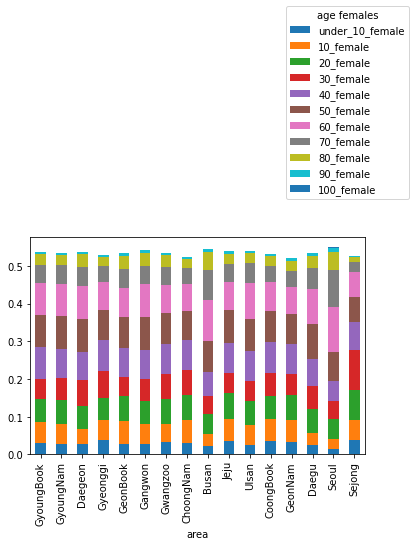

In [35]:
age_gender[[
    'area',
    'under_10_female', 
    '10_female', 
    '20_female', 
    '30_female', 
    '40_female',
    '50_female', 
    '60_female',  
    '70_female',
    '80_female', 
    '90_female',
    '100_female' 
]].plot.bar(x='area',stacked=True).legend(bbox_to_anchor=(0.75,1.15),ncol=1,title="age females")

In [36]:
df_1=data_frame.merge(age_gender, how='left')
df_1

,complex_code,total_number_household,rental_bulding_classification,area,supply_type,exclusive_area,number_of_household_by_area,public_price,qualification_type,rental_deposit,rent,subway,bus,parking_area,registried_vehicle,under_10_female,under_10_male,10_female,10_male,20_female,20_male,30_female,30_male,40_female,40_male,50_female,50_male,60_female,60_male,70_female,70_male,80_female,80_male,90_female,90_male,100_female,100_male
0,C2483,900,아파트,GyoungBook,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,C2483,900,아파트,GyoungBook,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
2,C2483,900,아파트,GyoungBook,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
3,C2483,900,아파트,GyoungBook,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
4,C2483,900,아파트,GyoungBook,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,C1267,675,아파트,GyoungNam,행복주택,36.77,126,38.0,L,NaN,NaN,0.0,1.0,467.0,NaN,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
3970,C2189,382,아파트,GeonBook,국민임대,29.19,96,45.0,H,6872000,106400,0.0,2.0,300.0,NaN,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
3971,C2189,382,아파트,GeonBook,국민임대,29.19,20,45.0,H,6872000,106400,0.0,2.0,300.0,NaN,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
3972,C2189,382,아파트,GeonBook,국민임대,39.45,202,45.0,H,13410000,144600,0.0,2.0,300.0,NaN,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


In [37]:
df_1.drop(['complex_code'], axis=1)

,total_number_household,rental_bulding_classification,area,supply_type,exclusive_area,number_of_household_by_area,public_price,qualification_type,rental_deposit,rent,subway,bus,parking_area,registried_vehicle,under_10_female,under_10_male,10_female,10_male,20_female,20_male,30_female,30_male,40_female,40_male,50_female,50_male,60_female,60_male,70_female,70_male,80_female,80_male,90_female,90_male,100_female,100_male
0,900,아파트,GyoungBook,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,900,아파트,GyoungBook,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
2,900,아파트,GyoungBook,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
3,900,아파트,GyoungBook,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
4,900,아파트,GyoungBook,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,675,아파트,GyoungNam,행복주택,36.77,126,38.0,L,NaN,NaN,0.0,1.0,467.0,NaN,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
3970,382,아파트,GeonBook,국민임대,29.19,96,45.0,H,6872000,106400,0.0,2.0,300.0,NaN,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
3971,382,아파트,GeonBook,국민임대,29.19,20,45.0,H,6872000,106400,0.0,2.0,300.0,NaN,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
3972,382,아파트,GeonBook,국민임대,39.45,202,45.0,H,13410000,144600,0.0,2.0,300.0,NaN,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


### Feature Selection

In [38]:
selected_features=[
                   'total_number_household',
                   'rental_bulding_classification',
                   'area',
                   'supply_type',
                   'exclusive_area',
                   'number_of_household_by_area',
                   'public_price',
                   'qualification_type',
                   'rental_deposit',
                   'rent',
                   'parking_area',
                   'subway',
                   'bus'	
]



df_1 = df_1[selected_features]

In [39]:
encoded_df = pd.get_dummies(df_1)

#### Resplit the DataFrame

In [40]:
encoded_train=encoded_df[0:2952]
encoded_test=encoded_df[2952:]
Y,fitted_lambda= boxcox(train['registried_vehicle'],lmbda=None)

#### Normalization

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

encoded_train_scaled = scaler.fit_transform(np.array(encoded_train))
encoded_test_scaled = scaler.fit_transform(np.array(encoded_test))

## Parameter Tuning

In [42]:
model = XGBRegressor(tree_method='gpu_hist')

param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100,200],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgb_reg = RandomizedSearchCV(estimator = model, param_distributions = param_lst,n_iter = 20, scoring = 'neg_mean_absolute_error', cv = 5)      
xgb_search = xgb_reg.fit(encoded_train_scaled, Y)

# XGB with tune hyperparameters
best_param = xgb_search.best_params_
model = XGBRegressor(**best_param)
print(best_param)

[11:22:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [43]:
kwargs={'reg_lambda':0.1, 'reg_alpha':0.01, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.15}

model = XGBRegressor(tree_method='gpu_hist'
                     )
model.set_params(**kwargs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model,encoded_train_scaled, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
model.fit(encoded_train_scaled, Y, eval_metric=['mae'])
y_pred = model.predict(encoded_test_scaled)

# reverse transformation
y_pred =inv_boxcox(y_pred, fitted_lambda)

# summarize prediction
predictions = [int(value) for value in y_pred]

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean MAE: 0.827 (0.037)
[11:30:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [45]:
submission = pd.DataFrame({
        "code": test["complex_code"],
        "num": predictions
    })

submission=submission.drop_duplicates(subset=['code'], keep='last')

submission.to_csv('submission.csv',index=False)